In [1]:
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout, Dense, Lambda, Reshape, Activation, Multiply, Add
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import backend as K
from tensorflow import keras
import tensorflow as tf
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

2024-03-16 00:49:54.271902: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 186/186 [00:00<00:00, 191.91it/s]


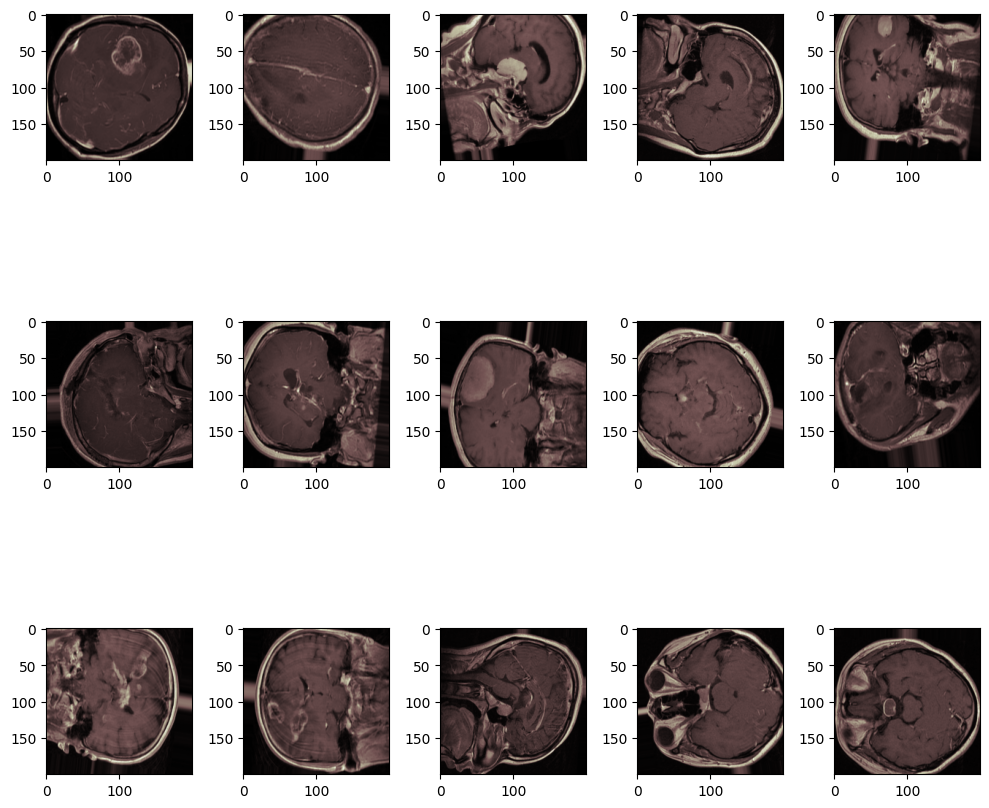

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


In [23]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [2]:
def block(inputs, filters):

    m = Conv2D(filters, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Concatenate()([m, a])

    d = Conv2D(filters * 2, 3, padding='same')(b)
    d = BatchNormalization()(d)
    d = ReLU()(d)

    d = Conv2D(filters * 2, 3, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    x = Concatenate()([b, d])

    m = Conv2D(filters*4, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)
    
    x = Add()([m, x])

    y = Conv2D(filters*2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y


def channel_attention(inputs, reduction=8):
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Multiply()([x, inputs])
    
    return x

def new_attention(inputs):

    b, h, w, c = inputs.shape.as_list()

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(inputs)

    x = tf.reshape(x, [-1, 1, h*w])
    y = tf.reshape(y, [-1, 1, h*w])

    x = K.batch_dot(x, tf.reshape(inputs, [-1, h*w, c]))
    y = K.batch_dot(y, tf.reshape(inputs, [-1, h*w, c]))

    x = tf.reshape(x, [-1, 1, 1, c])
    y = tf.reshape(y, [-1, 1, 1, c])

    z = Multiply()([x, y])
    x = Activation('sigmoid')(z)

    y = channel_attention(inputs)
    x = Add()([x, y])
    
    x = Multiply()([x, inputs])

    return x


def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    
    x = new_attention(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

In [25]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 200, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [26]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-test.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.5956 - accuracy: 0.7630
Epoch 1: val_accuracy improved from -inf to 0.33491, saving model to model-test.h5
Epoch 1: 15.80 seconds
264/264 [==============================] - 16s 53ms/step - loss: 0.5953 - accuracy: 0.7631 - val_loss: 3.9858 - val_accuracy: 0.3349 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.8798
Epoch 2: val_accuracy improved from 0.33491 to 0.36338, saving model to model-test.h5
Epoch 2: 13.49 seconds
264/264 [==============================] - 13s 51ms/step - loss: 0.3069 - accuracy: 0.8798 - val_loss: 8.3812 - val_accuracy: 0.3634 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9279
Epoch 3: val_accuracy improved from 0.36338 to 0.92979, saving model to model-test.h5
Epoch 3: 13.53 seconds
264/264 [==============================] - 14s 51ms/step - loss: 0.1934 - accuracy: 0.92

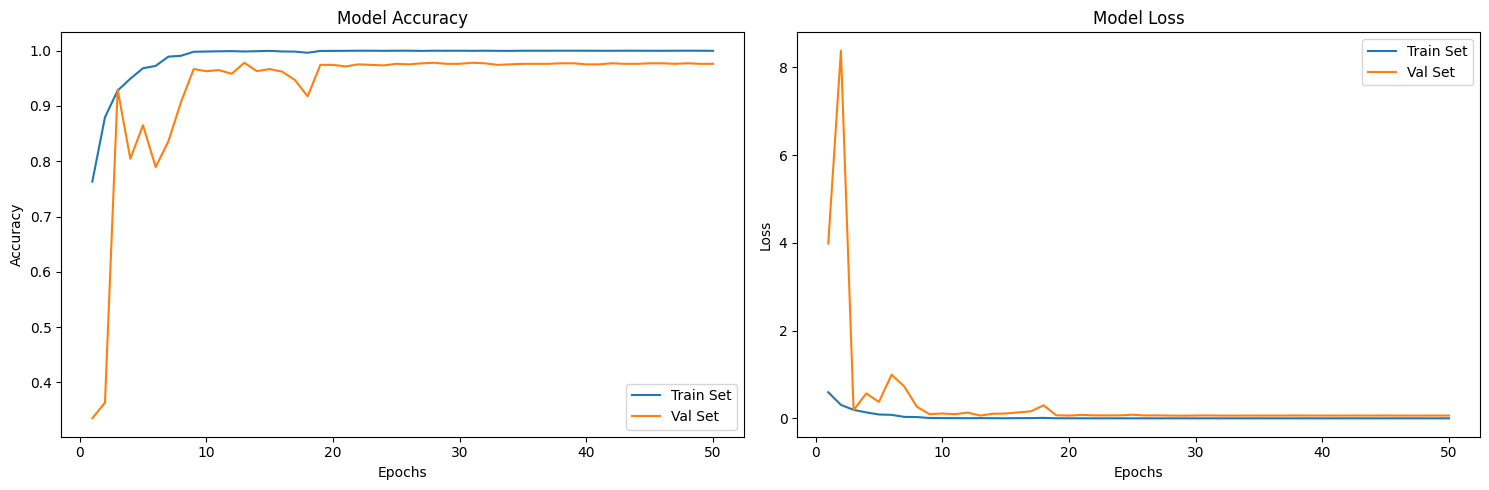

In [27]:
draw_curve(history)

20/20 [==============================] - 0s 15ms/step - loss: 0.0888 - accuracy: 0.9707
Test Accuracy:  97.07
              precision    recall  f1-score   support

      glioma     0.9759    0.9895    0.9826       286
  meningioma     0.9493    0.9225    0.9357       142
   pituitary     0.9785    0.9785    0.9785       186

    accuracy                         0.9707       614
   macro avg     0.9679    0.9635    0.9656       614
weighted avg     0.9705    0.9707    0.9705       614



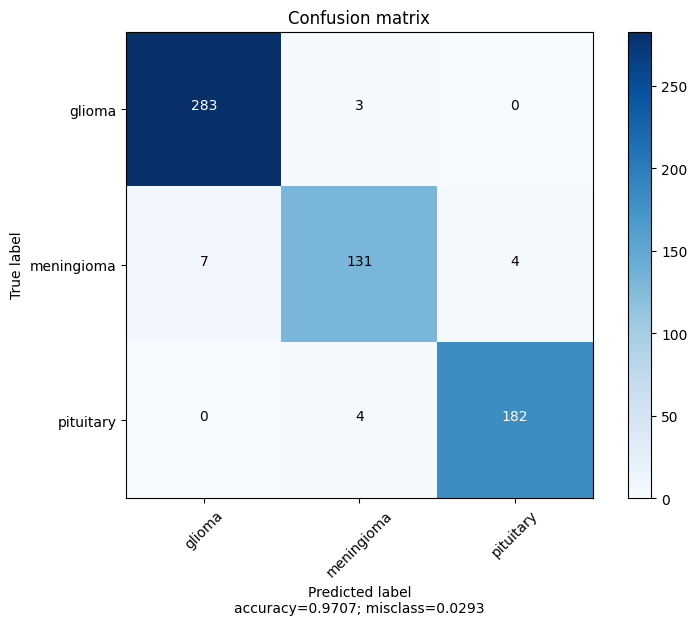

In [28]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

In [8]:
%reset -f

100%|██████████| 186/186 [00:00<00:00, 192.56it/s]


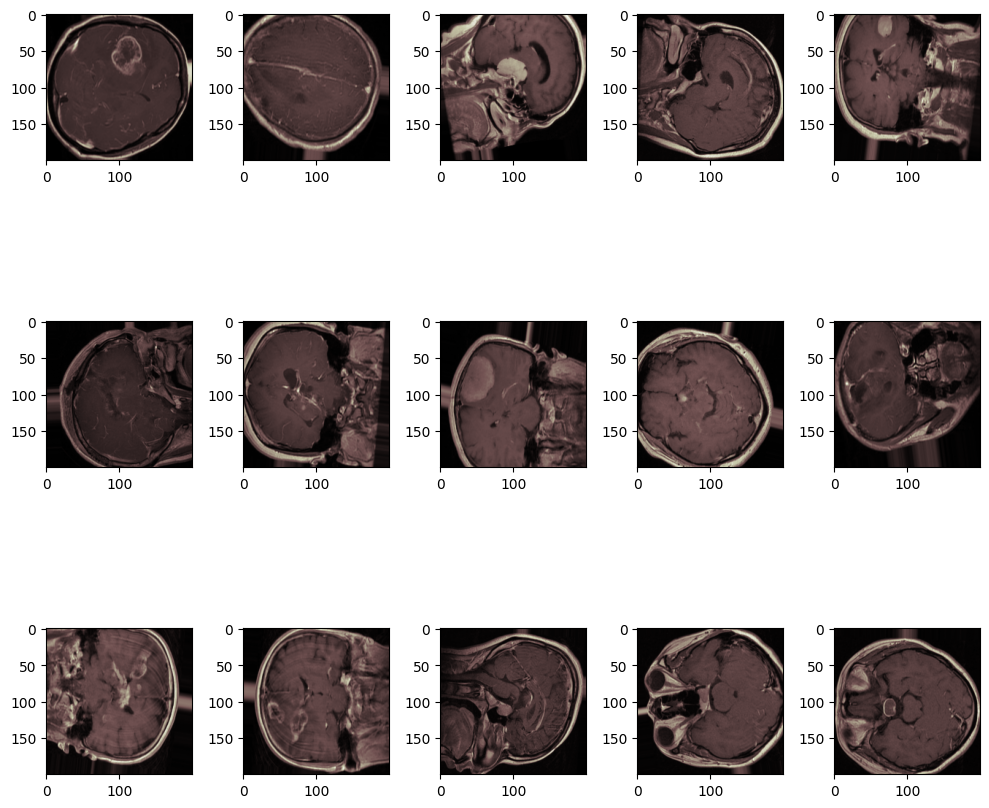

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.7504
Epoch 1: val_accuracy improved from -inf to 0.34725, saving model to model-test.h5
Epoch 1: 16.65 seconds
264/264 [==============================] - 17s 54ms/step - loss: 0.6323 - accuracy: 0.7504 - val_loss: 6.1336 - val_accuracy: 0.3472 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.8752
Epoch 2: val_accuracy improved from 0.34725 to 0.47913, saving model to model-test.h5
Epoch 2: 13.52 seconds
264/264 [==============================] - 14s 51ms/step - loss: 0.3268 - accuracy: 0.8752 - val_loss: 5.0979 - val_accuracy: 0.4791 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9193
Epoch 3: val_accuracy improved from 0.47913 to 0.86622, saving model to model-test.h5
Epoch 3: 13.53 seconds
264/264 [===================

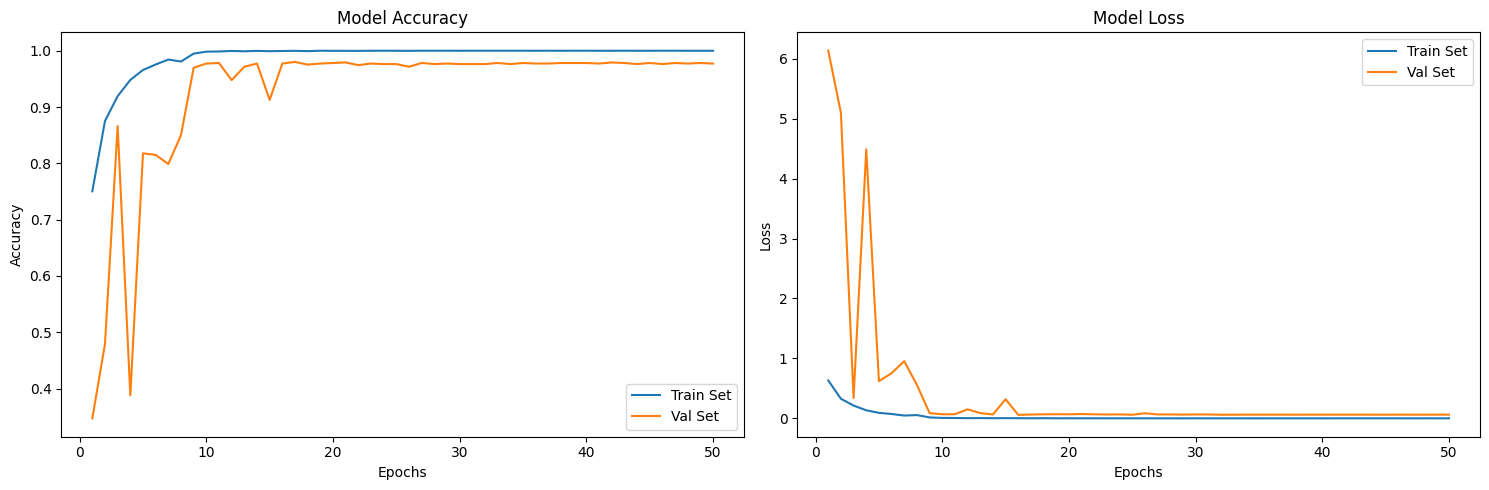

20/20 [==============================] - 0s 15ms/step - loss: 0.0812 - accuracy: 0.9723
Test Accuracy:  97.23
              precision    recall  f1-score   support

      glioma     0.9693    0.9930    0.9810       286
  meningioma     0.9706    0.9296    0.9496       142
   pituitary     0.9784    0.9731    0.9757       186

    accuracy                         0.9723       614
   macro avg     0.9727    0.9652    0.9688       614
weighted avg     0.9723    0.9723    0.9722       614



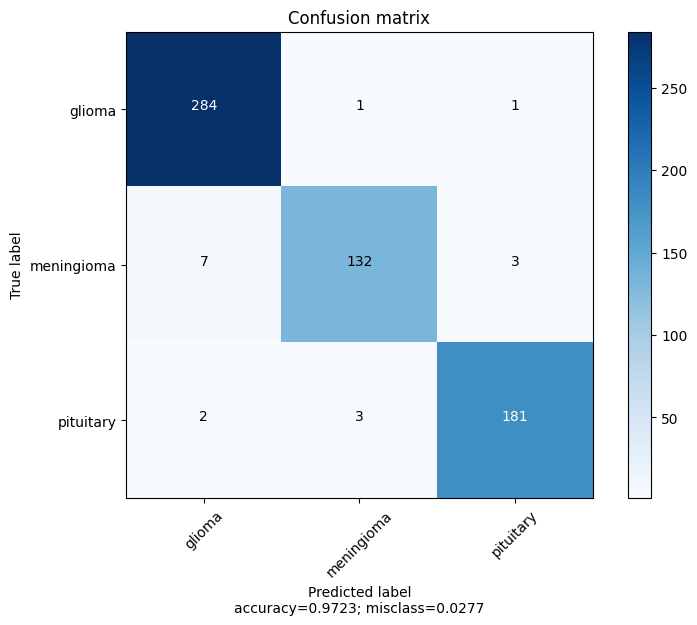

In [12]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-test.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 193.43it/s]


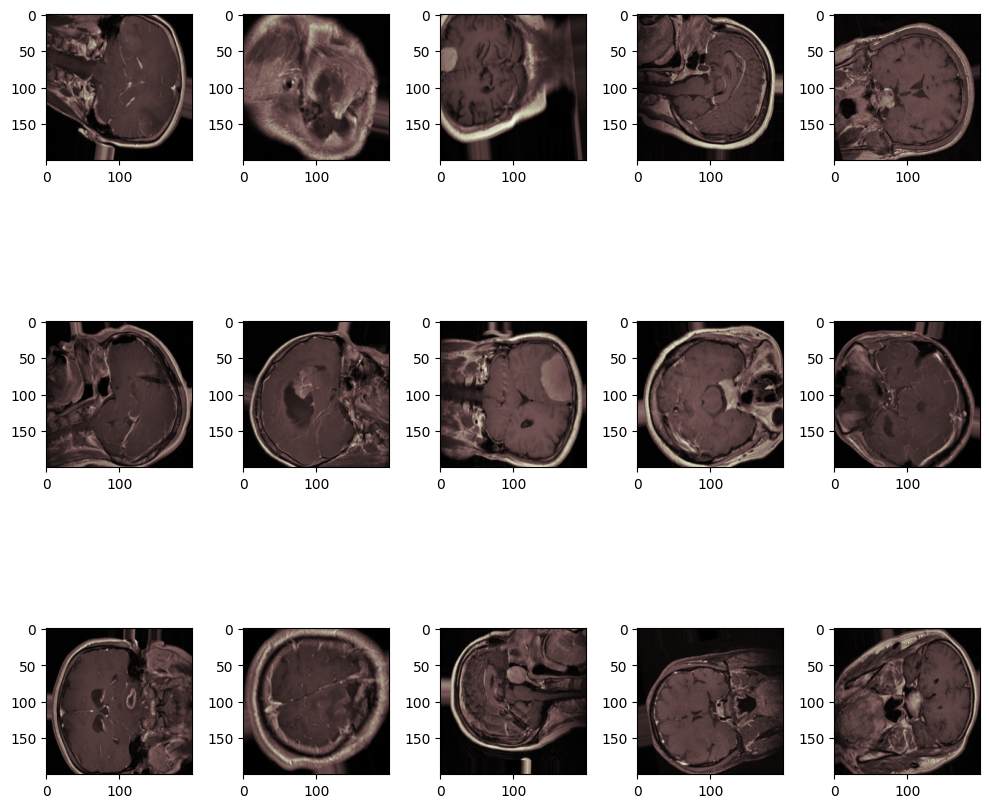

2024-03-16 00:51:10.420551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 00:51:10.724571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:41:00.0, compute capability: 8.9


Epoch 1/50


2024-03-16 00:51:19.458762: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2024-03-16 00:51:20.309646: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-16 00:51:20.309676: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-16 00:51:20.309815: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-16 00:51:21.060088: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.7476
Epoch 1: val_accuracy improved from -inf to 0.37761, saving model to model-test.h5
Epoch 1: 20.35 seconds
264/264 [==============================] - 20s 56ms/step - loss: 0.6336 - accuracy: 0.7476 - val_loss: 6.0718 - val_accuracy: 0.3776 - lr: 0.0010
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3937 - accuracy: 0.8464
Epoch 2: val_accuracy did not improve from 0.37761
Epoch 2: 13.03 seconds
264/264 [==============================] - 13s 49ms/step - loss: 0.3932 - accuracy: 0.8466 - val_loss: 20.4159 - val_accuracy: 0.3321 - lr: 0.0010
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.3137 - accuracy: 0.8792
Epoch 3: val_accuracy improved from 0.37761 to 0.72391, saving model to model-test.h5
Epoch 3: 13.25 seconds
264/264 [==============================] - 13s 50ms/step - loss: 0.3137 - accuracy: 0.8792 - val_loss: 0.8927 - val_accuracy: 0.7239 - lr: 0.

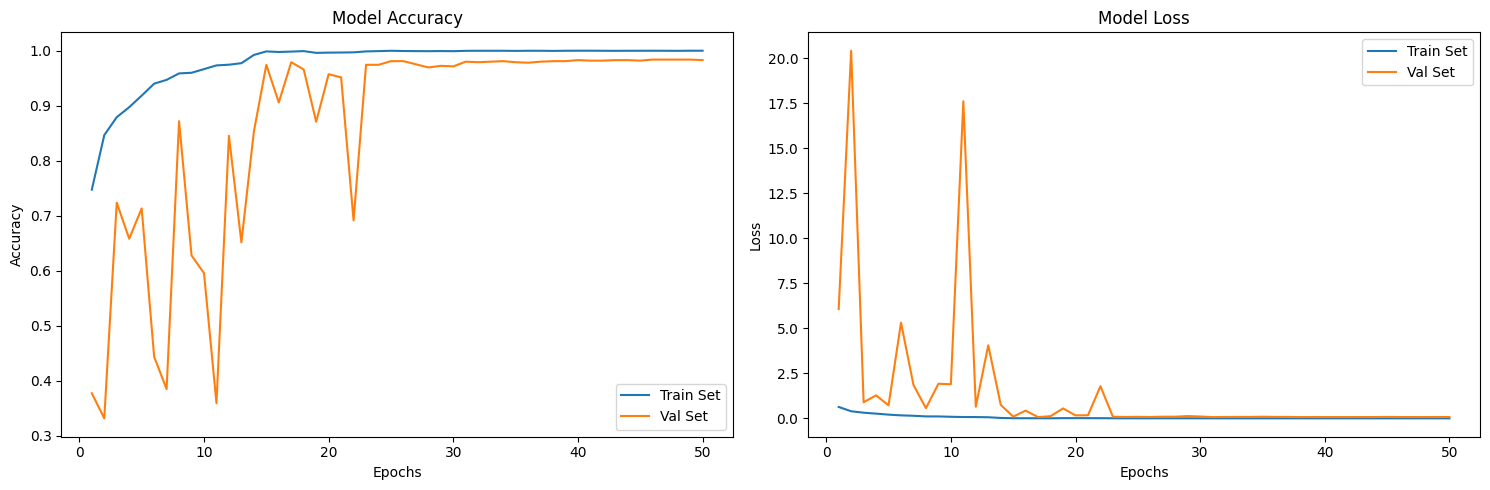

20/20 [==============================] - 0s 13ms/step - loss: 0.1433 - accuracy: 0.9691
Test Accuracy:  96.91
              precision    recall  f1-score   support

      glioma     0.9756    0.9790    0.9773       286
  meningioma     0.9371    0.9437    0.9404       142
   pituitary     0.9837    0.9731    0.9784       186

    accuracy                         0.9691       614
   macro avg     0.9655    0.9653    0.9653       614
weighted avg     0.9691    0.9691    0.9691       614



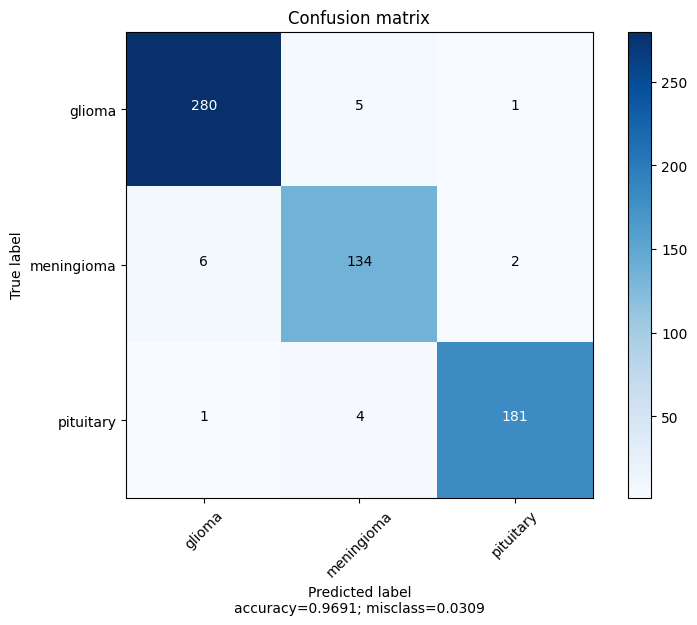

In [3]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-test.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 194.83it/s]


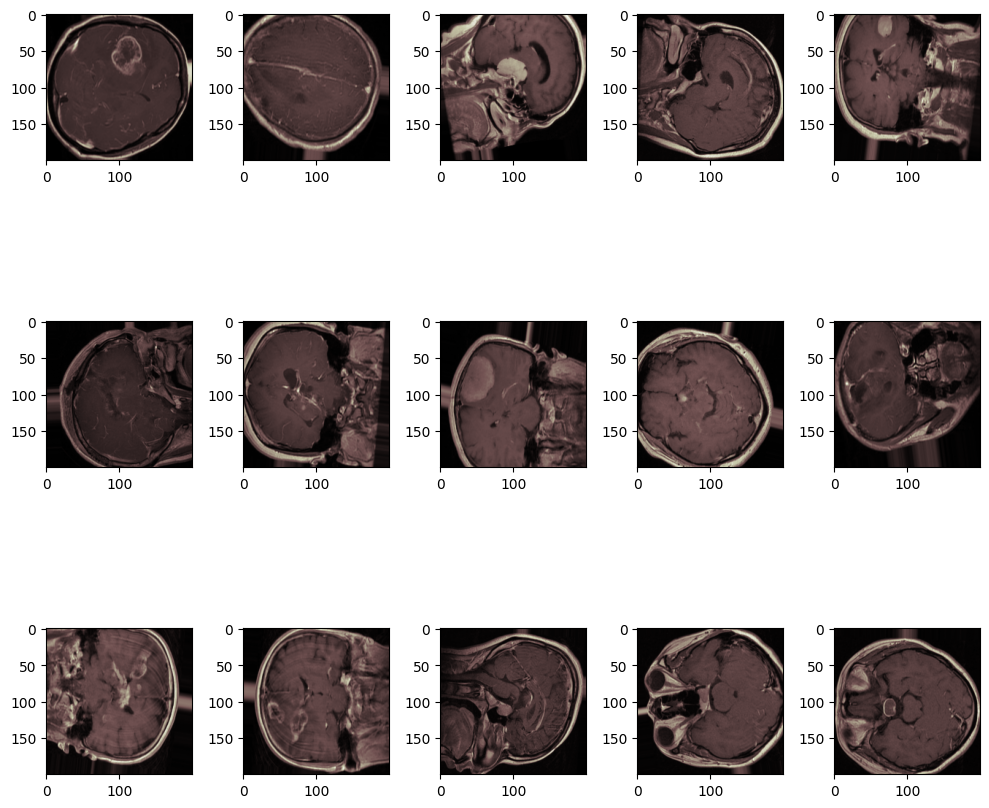

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.6304 - accuracy: 0.7471
Epoch 1: val_accuracy improved from -inf to 0.44687, saving model to model-test.h5
Epoch 1: 15.74 seconds
264/264 [==============================] - 16s 53ms/step - loss: 0.6299 - accuracy: 0.7473 - val_loss: 4.4117 - val_accuracy: 0.4469 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3355 - accuracy: 0.8700
Epoch 2: val_accuracy did not improve from 0.44687
Epoch 2: 13.14 seconds
264/264 [==============================] - 13s 50ms/step - loss: 0.3364 - accuracy: 0.8699 - val_loss: 16.0853 - val_accuracy: 0.3330 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9198
Epoch 3: val_accuracy improved from 0.44687 to 0.65560, saving model to model-test.h5
Epoch 3: 13.39 seconds
264/264 [==============================] - 13s 51ms/step - los

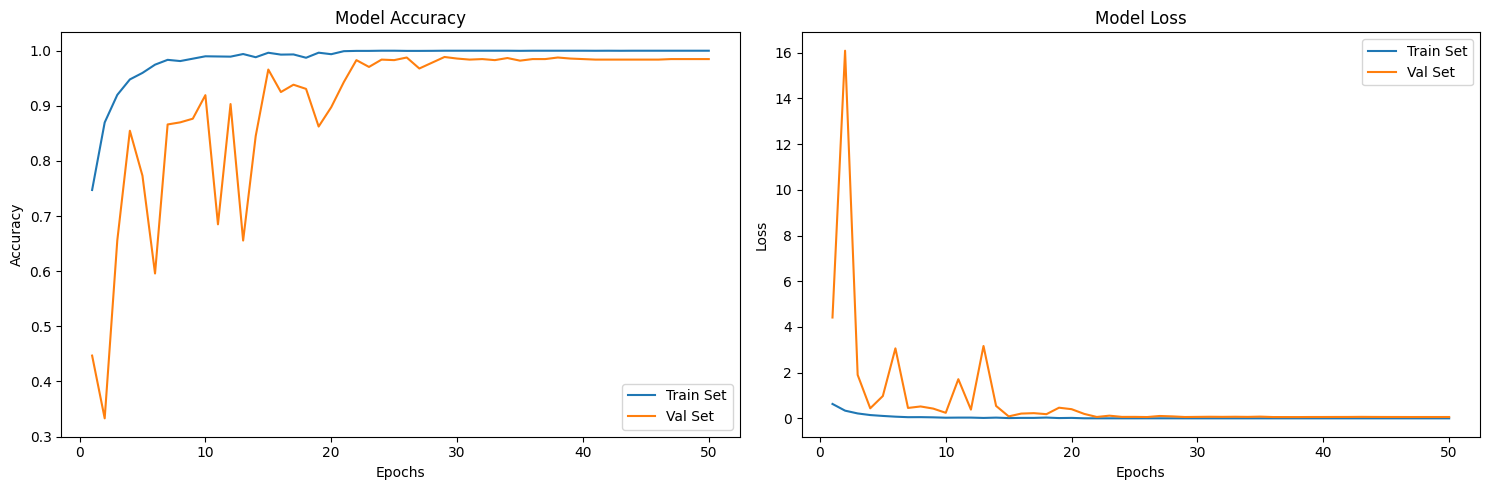

20/20 [==============================] - 0s 15ms/step - loss: 0.0799 - accuracy: 0.9756
Test Accuracy:  97.56
              precision    recall  f1-score   support

      glioma     0.9759    0.9930    0.9844       286
  meningioma     0.9571    0.9437    0.9504       142
   pituitary     0.9891    0.9731    0.9810       186

    accuracy                         0.9756       614
   macro avg     0.9741    0.9699    0.9719       614
weighted avg     0.9756    0.9756    0.9755       614



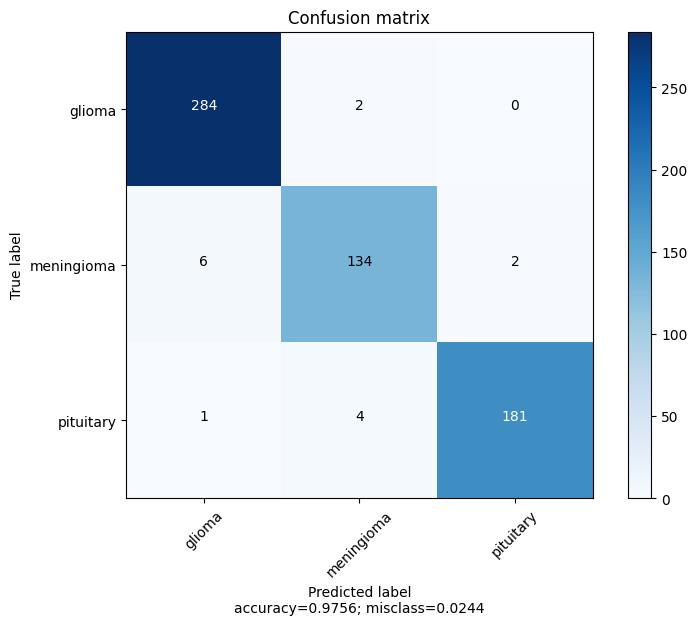

In [ ]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-test.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 193.07it/s]


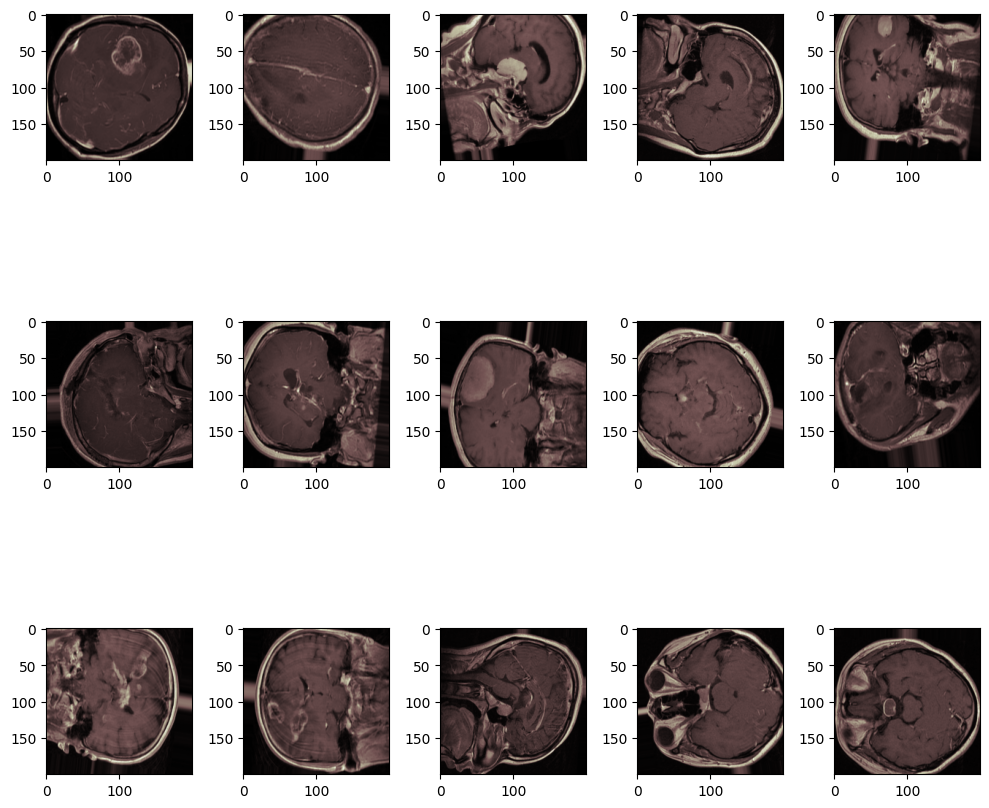

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.7426
Epoch 1: val_accuracy improved from -inf to 0.33586, saving model to model-test.h5
Epoch 1: 15.73 seconds
264/264 [==============================] - 16s 53ms/step - loss: 0.6379 - accuracy: 0.7426 - val_loss: 5.4318 - val_accuracy: 0.3359 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8765
Epoch 2: val_accuracy improved from 0.33586 to 0.36243, saving model to model-test.h5
Epoch 2: 13.47 seconds
264/264 [==============================] - 13s 51ms/step - loss: 0.3226 - accuracy: 0.8766 - val_loss: 5.2404 - val_accuracy: 0.3624 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2064 - accuracy: 0.9218
Epoch 3: val_accuracy improved from 0.36243 to 0.63188, saving model to model-test.h5
Epoch 3: 13.50 seconds
264/264 [===================

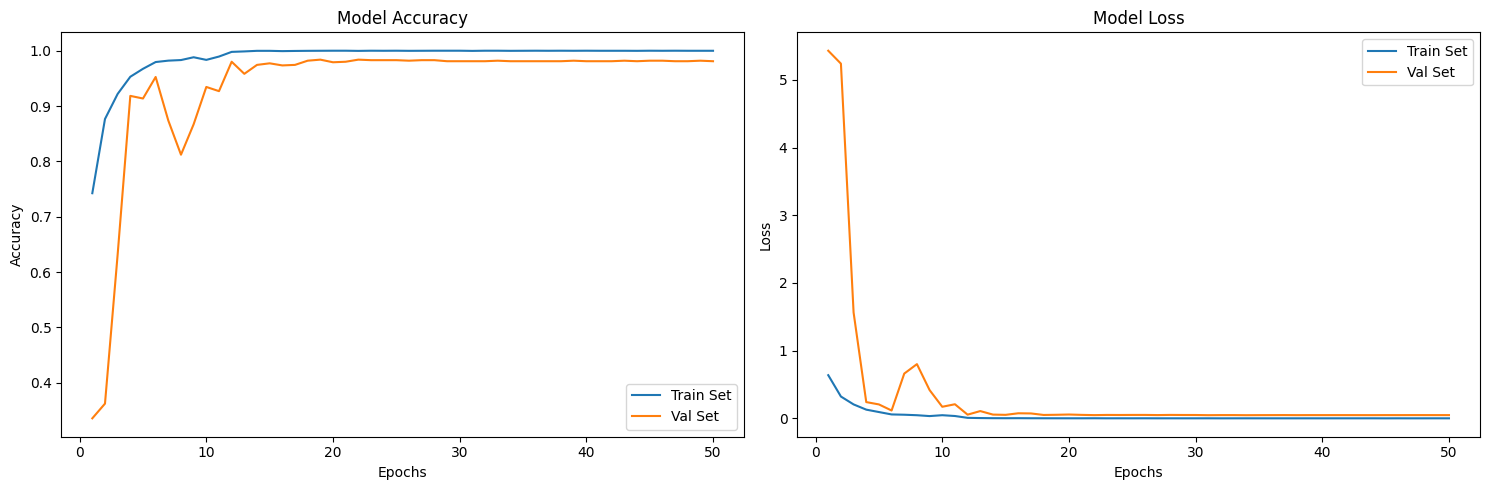

20/20 [==============================] - 0s 14ms/step - loss: 0.0801 - accuracy: 0.9739
Test Accuracy:  97.39
              precision    recall  f1-score   support

      glioma     0.9727    0.9965    0.9845       286
  meningioma     0.9638    0.9366    0.9500       142
   pituitary     0.9836    0.9677    0.9756       186

    accuracy                         0.9739       614
   macro avg     0.9734    0.9670    0.9700       614
weighted avg     0.9739    0.9739    0.9738       614



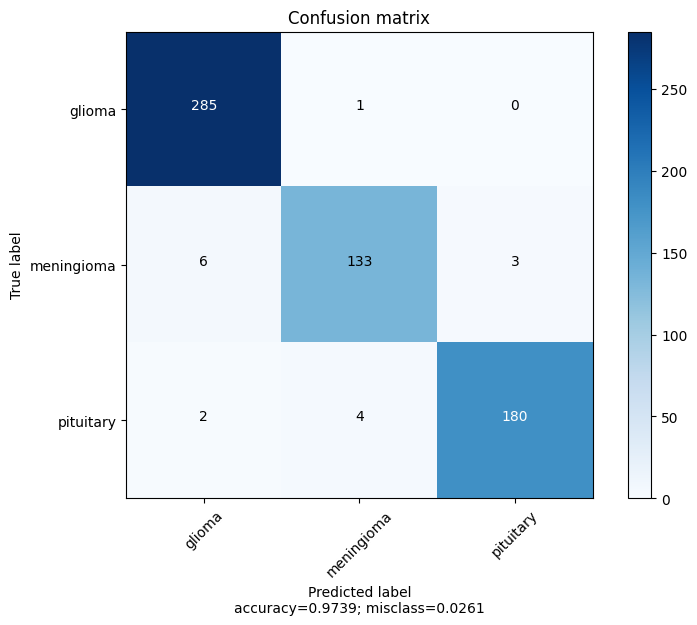

In [21]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-test.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f